## import packages

In [1]:
from torchvision import transforms, models
import os
import pandas as pd
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from ptflops import get_model_complexity_info
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## TASK A dynamic conv

In [ ]:
# ========== Channel Conversion ==========
def convert_channels(img, mode):
    r, g, b = img.split()
    zero = Image.new("L", img.size)
    if mode == "RGB":
        return Image.merge("RGB", (r, g, b))
    elif mode == "RG":
        return Image.merge("RGB", (r, g, zero))
    elif mode == "GB":
        return Image.merge("RGB", (zero, g, b))
    elif mode == "RB":
        return Image.merge("RGB", (r, zero, b))
    else:
        raise ValueError(f"Unknown channel mode: {mode}")

# ========== Dataset ========== 
class ImageDataset(Dataset):
    def __init__(self, csv_path, channel_mode="RGB", transform=None):
        self.df = pd.read_csv(csv_path)
        self.channel_mode = channel_mode
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['full_path']).convert("RGB")
        img = convert_channels(img, self.channel_mode)
        img = self.transform(img)
        return img, int(row['label'])

# ========== NaiveConv ==========
class NaiveConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x)

# ========== DynamicConv ==========
class DynamicConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, K=4, hidden_dim=128):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.K = K
        self.hidden_dim = hidden_dim
        self.total_params = out_channels * in_channels * kernel_size * kernel_size

        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(in_channels, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, K),
            nn.Softmax(dim=1)
        )

        self.kernel_generator = nn.ModuleList([
            nn.Sequential(
                nn.Linear(in_channels, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, self.total_params)
            ) for _ in range(K)
        ])

        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        B, C, H, W = x.shape
        attn_weights = self.attention(x)
        pooled = F.adaptive_avg_pool2d(x, 1).view(B, C)
        dynamic_kernels = []
        for k in range(self.K):
            kernels = self.kernel_generator[k](pooled)
            kernels = kernels.view(B, self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)
            dynamic_kernels.append(kernels)

        out = 0
        for k in range(self.K):
            kernels = dynamic_kernels[k]
            attn = attn_weights[:, k].view(B, 1, 1, 1, 1)
            weighted_kernel = kernels * attn
            tmp = [F.conv2d(x[i:i+1], weighted_kernel[i], padding=self.kernel_size//2) for i in range(B)]
            out += torch.cat(tmp, dim=0)

        out = self.bn(out)
        return F.relu(out)

# ========== Train / Eval / Test Functions ==========
def train_model(model, train_loader, val_loader, save_path, num_epochs=5, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_acc = 0
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            pooled = F.adaptive_avg_pool2d(outputs, 1).view(outputs.size(0), -1)
            loss = criterion(pooled, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

        acc = evaluate_model(model, val_loader)
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), save_path)
            print("Best model saved.")

def evaluate_model(model, dataloader):
    model.eval()
    device = next(model.parameters()).device
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            pooled = F.adaptive_avg_pool2d(outputs, 1).view(outputs.size(0), -1)
            preds = torch.argmax(pooled, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"Validation Accuracy: {acc:.4f}")
    return acc

def test_model(model, weights_path, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            pooled = F.adaptive_avg_pool2d(outputs, 1).view(outputs.size(0), -1)
            preds = torch.argmax(pooled, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"Test Accuracy: {acc:.4f}")
    return acc

# ========== Main Flow ==========
if __name__ == "__main__":
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    channel_mode = "RGB"
    train_loader = DataLoader(ImageDataset("train.csv", channel_mode, transform), batch_size=10, shuffle=True)
    val_loader = DataLoader(ImageDataset("val.csv", channel_mode, transform), batch_size=10)
    test_loader = DataLoader(ImageDataset("test.csv", channel_mode, transform), batch_size=10)

    # Train and evaluate DynamicConv
    dyn_model = DynamicConv(in_channels=3, out_channels=50)
    train_model(dyn_model, train_loader, val_loader, "dynamic_model.pth")
    test_model(dyn_model, "dynamic_model.pth", test_loader)

    # Train and evaluate NaiveConv
    naive_model = NaiveConv(in_channels=3, out_channels=50)
    train_model(naive_model, train_loader, val_loader, "naive_model.pth")
    test_model(naive_model, "naive_model.pth", test_loader)

    # Compute FLOPs comparison
    dyn_flops, dyn_params = get_model_complexity_info(DynamicConv(3, 10), (3, 128, 128), verbose=False)
    naive_flops, naive_params = get_model_complexity_info(NaiveConv(3, 10), (3, 128, 128), verbose=False)
    print("\n--- FLOPs / Params ---")
    print(f"DynamicConv: {dyn_flops} FLOPs, {dyn_params} Params")
    print(f"NaiveConv:   {naive_flops} FLOPs, {naive_params} Params")


Epoch 1, Loss: 3.7789
Validation Accuracy: 0.0733
Best model saved.
Epoch 2, Loss: 3.7355
Validation Accuracy: 0.0711
Epoch 3, Loss: 3.7143
Validation Accuracy: 0.0800
Best model saved.
Epoch 4, Loss: 3.6980
Validation Accuracy: 0.0689
Epoch 5, Loss: 3.6859
Validation Accuracy: 0.0800


C:\Users\User\AppData\Local\Temp\ipykernel_15352\2455129312.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location

Test Accuracy: 0.0822
Epoch 1, Loss: 3.8106
Validation Accuracy: 0.0556
Best model saved.
Epoch 2, Loss: 3.7820
Validation Accuracy: 0.0622
Best model saved.
Epoch 3, Loss: 3.7680
Validation Accuracy: 0.0578
Epoch 4, Loss: 3.7595
Validation Accuracy: 0.0600
Epoch 5, Loss: 3.7532
Validation Accuracy: 0.0689
Best model saved.
Test Accuracy: 0.0667
DynamicConv(
  142.42 k, 100.000% Params, 519.87 KMac, 66.424% MACs, 
  (attention): Sequential(
    1.03 k, 0.722% Params, 50.31 KMac, 6.428% MACs, 
    (0): AdaptiveAvgPool2d(0, 0.000% Params, 49.15 KMac, 6.280% MACs, output_size=1)
    (1): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
    (2): Linear(512, 0.360% Params, 512.0 Mac, 0.065% MACs, in_features=3, out_features=128, bias=True)
    (3): ReLU(0, 0.000% Params, 128.0 Mac, 0.016% MACs, )
    (4): Linear(516, 0.362% Params, 516.0 Mac, 0.066% MACs, in_features=128, out_features=4, bias=True)
    (5): Softmax(0, 0.000% Params, 0.0 Mac, 0.000% MACs, dim=1)
  )
 

## TASK B Resnet34（Baseline）

In [ ]:
# =============================
# 訓練參數
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
num_epochs = 10
num_classes = 50  # 根據你的資料設置類別數
learning_rate = 1e-4

# =============================
# 自訂資料集：使用 full_path 欄位
# =============================
class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['full_path']
        label = int(self.df.iloc[idx]['label'])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# =============================
# 資料轉換
# =============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# =============================
# 載入資料
# =============================
train_set = ImageDataset("train.csv", transform=transform)
val_set = ImageDataset("val.csv", transform=transform)
test_set = ImageDataset("test.csv", transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# =============================
# 模型定義：ResNet34
# =============================
model = models.resnet34(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# =============================
# 驗證函數
# =============================
def evaluate(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# =============================
# 模型訓練
# =============================
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    end_time = time.time()
    epoch_time = end_time - start_time

    avg_loss = running_loss / len(train_loader.dataset)
    val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f} - Val Accuracy: {val_acc:.4f} - Time: {epoch_time:.2f} sec")

# =============================
# 測試資料集最終評估
# =============================
test_acc = evaluate(model, test_loader)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 1979/1979 [37:47<00:00,  1.15s/it]


Epoch 1 - Loss: 2.9503 - Val Accuracy: 0.2822 - Time: 2267.11 sec


Epoch 2/10: 100%|██████████| 1979/1979 [14:37<00:00,  2.26it/s]


Epoch 2 - Loss: 2.2699 - Val Accuracy: 0.3356 - Time: 877.60 sec


Epoch 3/10: 100%|██████████| 1979/1979 [14:52<00:00,  2.22it/s]


Epoch 3 - Loss: 1.8583 - Val Accuracy: 0.4556 - Time: 892.13 sec


Epoch 4/10: 100%|██████████| 1979/1979 [14:51<00:00,  2.22it/s]


Epoch 4 - Loss: 1.5602 - Val Accuracy: 0.5289 - Time: 891.87 sec


Epoch 5/10: 100%|██████████| 1979/1979 [14:53<00:00,  2.22it/s]


Epoch 5 - Loss: 1.3255 - Val Accuracy: 0.5044 - Time: 893.24 sec


Epoch 6/10: 100%|██████████| 1979/1979 [12:33<00:00,  2.62it/s]


Epoch 6 - Loss: 1.1101 - Val Accuracy: 0.5533 - Time: 753.94 sec


Epoch 7/10: 100%|██████████| 1979/1979 [46:41<00:00,  1.42s/it]   


Epoch 7 - Loss: 0.9094 - Val Accuracy: 0.5178 - Time: 2801.78 sec


Epoch 8/10: 100%|██████████| 1979/1979 [21:40<00:00,  1.52it/s]


Epoch 8 - Loss: 0.7207 - Val Accuracy: 0.5733 - Time: 1300.63 sec


Epoch 9/10: 100%|██████████| 1979/1979 [12:32<00:00,  2.63it/s]


Epoch 9 - Loss: 0.5505 - Val Accuracy: 0.5733 - Time: 752.37 sec


Epoch 10/10: 100%|██████████| 1979/1979 [12:34<00:00,  2.62it/s]


Epoch 10 - Loss: 0.4249 - Val Accuracy: 0.5511 - Time: 754.94 sec

✅ Final Test Accuracy: 0.5422


## TASK B my model

In [ ]:
# -------------------------------
# 資料路徑
# -------------------------------
train_csv = "train.csv"
val_csv = "val.csv"
test_csv = "test.csv"

# -------------------------------
# 根據資料集計算 normalization mean 與 std，並寫死
# -------------------------------
def compute_mean_std_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    pixel_sum = torch.zeros(3)
    pixel_squared_sum = torch.zeros(3)
    num_images = 0
    for path in df['full_path']:
        image = Image.open(path).convert("RGB")
        image = transform(image)
        pixel_sum += image.mean(dim=[1, 2])
        pixel_squared_sum += (image ** 2).mean(dim=[1, 2])
        num_images += 1
    mean = (pixel_sum / num_images).tolist()
    std = (torch.sqrt(pixel_squared_sum / num_images - torch.tensor(mean) ** 2)).tolist()
    return mean, std

# 第一次執行時可打開這段來計算後寫死
train_mean, train_std = compute_mean_std_from_csv(train_csv)
print("train_mean =", train_mean)
print("train_std =", train_std)

train_mean = [0.47987017035484314, 0.4597013592720032, 0.38735413551330566]
train_std = [0.2513413429260254, 0.24211332201957703, 0.24762633442878723]


## mobilenet失敗

In [ ]:
"""train_mean = [0.48, 0.46, 0.39]
train_std = [0.24, 0.23, 0.24]

normalize_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

# -------------------------------
# Dataset 類別
# -------------------------------
class ImageDatasetFromCSV(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['full_path']
        label = int(self.df.iloc[idx]['label'])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# -------------------------------
# 建立 DataLoader
# -------------------------------
batch_size = 32
train_dataset = ImageDatasetFromCSV(train_csv, transform=normalize_transform)
val_dataset = ImageDatasetFromCSV(val_csv, transform=normalize_transform)
test_dataset = ImageDatasetFromCSV(test_csv, transform=normalize_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# -------------------------------
# MobileNetV3-Inspired Block（有效層）
# -------------------------------
class InvertedResidualBlock(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels, use_se=True, activation=F.hardswish):
        super().__init__()
        self.use_res_connect = in_channels == out_channels
        self.activation = activation

        self.expand = nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(hidden_dim)

        self.dwconv = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1, groups=hidden_dim, bias=False)
        self.bn2 = nn.BatchNorm2d(hidden_dim)

        self.use_se = use_se
        if use_se:
            self.se = SEBlock(hidden_dim)

        self.project = nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.activation(self.bn1(self.expand(x)))
        out = self.activation(self.bn2(self.dwconv(out)))
        if self.use_se:
            out = self.se(out)
        out = self.bn3(self.project(out))
        if self.use_res_connect:
            return x + out
        else:
            return out

# -------------------------------
# SE Block（非有效層）
# -------------------------------
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# -------------------------------
# 模型架構（TaskB 合法，有效層數 4）
# -------------------------------
class MobileNetLikeNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False),  # 有效層 1
            nn.BatchNorm2d(16),
            nn.Hardswish()
        )
        self.block1 = InvertedResidualBlock(16, 32, 16, use_se=True)  # 有效層 +3
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(16, 128),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.pool(x).view(x.size(0), -1)
        return self.classifier(x)

# -------------------------------
# 模型初始化與 FLOPs 統計
# -------------------------------
num_classes = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetLikeNet(num_classes).to(device)

print("\n模型參數與 FLOPs 統計：")
with torch.cuda.device(0):
    macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True,
                                             print_per_layer_stat=False, verbose=False)
print(f"FLOPs (MACs): {macs}")
print(f"參數總數（格式化）: {params}")
total_params = sum(p.numel() for p in model.parameters())
print(f"參數總數（數字）: {total_params:,}")

# -------------------------------
# 訓練設定
# -------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
num_epochs = 30
train_losses, val_losses = [], []

# -------------------------------
# 模型訓練流程（含時間與準確率）
# -------------------------------
for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    train_acc = correct_train / total_train

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    val_epoch_loss = val_running_loss / len(val_loader)
    val_losses.append(val_epoch_loss)
    val_acc = correct_val / total_val

    end_time = time.time()
    duration = end_time - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}, "
          f"Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%, Time: {duration:.2f} sec")

    # 新增：若 train acc 超過 95%，則提前停止
    if train_acc >= 0.95:
        print(f"Early stopping triggered: Train accuracy reached {train_acc*100:.2f}%")
        break

    scheduler.step()

# -------------------------------
# 畫出 Loss 曲線
# -------------------------------
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss", linestyle="--", color="green")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 測試集準確率
# -------------------------------
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
acc = accuracy_score(y_true, y_pred)
print(f"\n最終測試集準確率:{acc * 100:.2f}%")"""


模型參數與 FLOPs 統計：
FLOPs (MACs): 25.5 MMac
參數總數（格式化）: 11.11 k
參數總數（數字）: 11,114
Epoch [1/30], Train Loss: 3.4937, Val Loss: 3.2287, Train Acc: 10.06%, Val Acc: 11.78%, Time: 367.76 sec
Epoch [2/30], Train Loss: 3.2764, Val Loss: 3.0935, Train Acc: 13.82%, Val Acc: 14.00%, Time: 389.92 sec
Epoch [3/30], Train Loss: 3.1898, Val Loss: 3.0007, Train Acc: 15.27%, Val Acc: 15.78%, Time: 390.93 sec
Epoch [4/30], Train Loss: 3.1259, Val Loss: 2.9552, Train Acc: 16.62%, Val Acc: 15.78%, Time: 1268.23 sec
Epoch [5/30], Train Loss: 3.0783, Val Loss: 2.8810, Train Acc: 17.48%, Val Acc: 19.11%, Time: 565.89 sec
Epoch [6/30], Train Loss: 3.0134, Val Loss: 2.8548, Train Acc: 19.09%, Val Acc: 18.22%, Time: 923.50 sec
Epoch [7/30], Train Loss: 2.9935, Val Loss: 2.8351, Train Acc: 19.39%, Val Acc: 18.89%, Time: 595.89 sec
Epoch [8/30], Train Loss: 2.9732, Val Loss: 2.8201, Train Acc: 20.11%, Val Acc: 19.11%, Time: 896.41 sec
Epoch [9/30], Train Loss: 2.9535, Val Loss: 2.7956, Train Acc: 20.20%, Val Acc: 16

KeyboardInterrupt: 

## final model， like-efficientnet， epoch=50


模型參數與 FLOPs 統計：
FLOPs (MACs): 848.08 MMac
參數總數（格式化）: 1.34 M
參數總數（數字）: 1,341,298
Epoch [1/50], Train Loss: 3.4306, Val Loss: 2.8856, Train Acc: 10.73%, Val Acc: 17.11%, Time: 426.30 sec
Epoch [2/50], Train Loss: 2.9810, Val Loss: 2.6481, Train Acc: 19.05%, Val Acc: 22.22%, Time: 408.63 sec
Epoch [3/50], Train Loss: 2.6821, Val Loss: 2.4646, Train Acc: 25.15%, Val Acc: 26.67%, Time: 412.94 sec
Epoch [4/50], Train Loss: 2.4320, Val Loss: 2.2699, Train Acc: 30.82%, Val Acc: 31.56%, Time: 422.61 sec
Epoch [5/50], Train Loss: 2.2088, Val Loss: 1.9862, Train Acc: 36.15%, Val Acc: 36.22%, Time: 411.89 sec
Epoch [6/50], Train Loss: 1.9427, Val Loss: 1.7445, Train Acc: 42.71%, Val Acc: 43.11%, Time: 385.29 sec
Epoch [7/50], Train Loss: 1.8210, Val Loss: 1.7021, Train Acc: 45.69%, Val Acc: 43.56%, Time: 375.55 sec
Epoch [8/50], Train Loss: 1.7269, Val Loss: 1.6537, Train Acc: 48.18%, Val Acc: 46.67%, Time: 378.49 sec
Epoch [9/50], Train Loss: 1.6326, Val Loss: 1.5781, Train Acc: 50.40%, Val Acc:

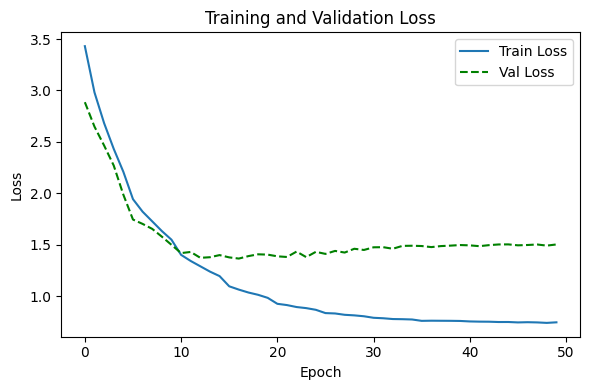


最終測試集準確率:55.78%


In [ ]:
# -------------------------------
# 資料路徑
# -------------------------------
train_csv = "train.csv"
val_csv = "val.csv"
test_csv = "test.csv"

# -------------------------------
# Normalization 參數（寫死）
# -------------------------------
train_mean = [0.48, 0.46, 0.39]
train_std = [0.24, 0.23, 0.24]

normalize_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

# -------------------------------
# Dataset 類別
# -------------------------------
class ImageDatasetFromCSV(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['full_path']
        label = int(self.df.iloc[idx]['label'])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# -------------------------------
# 建立 DataLoader
# -------------------------------
batch_size = 64
train_dataset = ImageDatasetFromCSV(train_csv, transform=normalize_transform)
val_dataset = ImageDatasetFromCSV(val_csv, transform=normalize_transform)
test_dataset = ImageDatasetFromCSV(test_csv, transform=normalize_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# -------------------------------
# SE Block（非有效層）
# -------------------------------
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# -------------------------------
# 符合 TaskB 的 EfficientNet-like 精簡模型（4 個有效層）
# -------------------------------
class EfficientNetMini(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False)  # 有效層 1
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 有效層 2
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=7, stride=2, padding=3, bias=False)  # 有效層 3
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=7, stride=2, padding=3, bias=False)  # 有效層 4
        self.bn4 = nn.BatchNorm2d(128)

        self.se = SEBlock(128)  # 非有效層
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = F.silu(self.bn1(self.conv1(x)))
        x = F.silu(self.bn2(self.conv2(x)))
        x = F.silu(self.bn3(self.conv3(x)))
        x = F.silu(self.bn4(self.conv4(x)))
        x = self.se(x)
        x = self.pool(x).view(x.size(0), -1)
        return self.fc(x)

num_classes = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetMini(num_classes).to(device)

print("\n模型參數與 FLOPs 統計：")
with torch.cuda.device(0):
    macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True,
                                             print_per_layer_stat=False, verbose=False)
print(f"FLOPs (MACs): {macs}")
print(f"參數總數（格式化）: {params}")
total_params = sum(p.numel() for p in model.parameters())
print(f"參數總數（數字）: {total_params:,}")

# -------------------------------
# 模型訓練與驗證（增加 Epoch 輸出）
# -------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
num_epochs = 30
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    train_acc = correct_train / total_train

    model.eval()
    val_running_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    val_epoch_loss = val_running_loss / len(val_loader)
    val_losses.append(val_epoch_loss)
    val_acc = correct_val / total_val

    end_time = time.time()
    duration = end_time - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}, "
          f"Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%, Time: {duration:.2f} sec")

    scheduler.step()

# -------------------------------
# 畫出 Loss 曲線
# -------------------------------
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss", linestyle="--", color="green")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 測試集準確率
# -------------------------------
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
acc = accuracy_score(y_true, y_pred)
print(f"\n最終測試集準確率:{acc * 100:.2f}%")

## 消融測試1 ，epoch=30 ， 修改kernal大小變成3*3 


模型參數與 FLOPs 統計：
FLOPs (MACs): 157.66 MMac
參數總數（格式化）: 272.5 k
參數總數（數字）: 272,498
Epoch [1/30], Train Loss: 3.4394, Val Loss: 2.9720, Train Acc: 10.43%, Val Acc: 16.44%, Time: 373.86 sec
Epoch [2/30], Train Loss: 3.0550, Val Loss: 2.6303, Train Acc: 17.56%, Val Acc: 20.00%, Time: 319.15 sec
Epoch [3/30], Train Loss: 2.7948, Val Loss: 2.6157, Train Acc: 23.25%, Val Acc: 22.89%, Time: 313.63 sec
Epoch [4/30], Train Loss: 2.5785, Val Loss: 2.2791, Train Acc: 27.81%, Val Acc: 30.00%, Time: 314.77 sec
Epoch [5/30], Train Loss: 2.3934, Val Loss: 2.1504, Train Acc: 31.82%, Val Acc: 32.00%, Time: 316.36 sec
Epoch [6/30], Train Loss: 2.1700, Val Loss: 1.9359, Train Acc: 37.33%, Val Acc: 37.11%, Time: 316.46 sec
Epoch [7/30], Train Loss: 2.0832, Val Loss: 1.9311, Train Acc: 39.38%, Val Acc: 40.67%, Time: 315.20 sec
Epoch [8/30], Train Loss: 2.0209, Val Loss: 1.8329, Train Acc: 40.84%, Val Acc: 40.44%, Time: 315.81 sec
Epoch [9/30], Train Loss: 1.9541, Val Loss: 1.8153, Train Acc: 42.39%, Val Acc: 

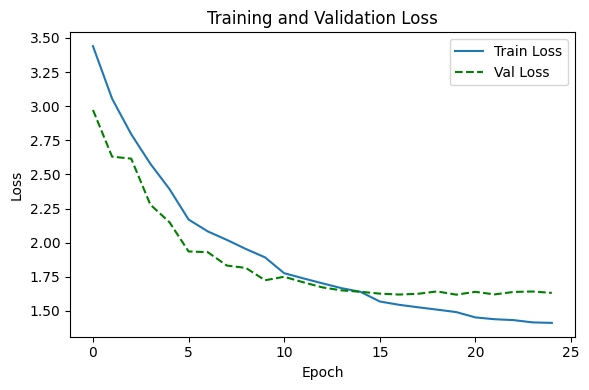


最終測試集準確率: 49.11%
Precision: 0.5050
Recall:    0.4911
F1-score:  0.4855


In [3]:
# -------------------------------
# 資料路徑
# -------------------------------
train_csv = "train.csv"
val_csv = "val.csv"
test_csv = "test.csv"

# -------------------------------
# Normalization 參數（寫死）
# -------------------------------
train_mean = [0.48, 0.46, 0.39]
train_std = [0.24, 0.23, 0.24]

normalize_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

# -------------------------------
# Dataset 類別
# -------------------------------
class ImageDatasetFromCSV(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['full_path']
        label = int(self.df.iloc[idx]['label'])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# -------------------------------
# 建立 DataLoader
# -------------------------------
batch_size = 64
train_dataset = ImageDatasetFromCSV(train_csv, transform=normalize_transform)
val_dataset = ImageDatasetFromCSV(val_csv, transform=normalize_transform)
test_dataset = ImageDatasetFromCSV(test_csv, transform=normalize_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


# -------------------------------
# SE Block（非有效層）
# -------------------------------
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# -------------------------------
# 符合 TaskB 的 EfficientNet-like 精簡模型（kernel = 3）
# -------------------------------
class EfficientNetMini(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.se = SEBlock(128)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = F.silu(self.bn1(self.conv1(x)))
        x = F.silu(self.bn2(self.conv2(x)))
        x = F.silu(self.bn3(self.conv3(x)))
        x = F.silu(self.bn4(self.conv4(x)))
        x = self.se(x)
        x = self.pool(x).view(x.size(0), -1)
        return self.fc(x)

num_classes = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetMini(num_classes).to(device)

print("\n模型參數與 FLOPs 統計：")
with torch.cuda.device(0):
    macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True,
                                             print_per_layer_stat=False, verbose=False)
print(f"FLOPs (MACs): {macs}")
print(f"參數總數（格式化）: {params}")
total_params = sum(p.numel() for p in model.parameters())
print(f"參數總數（數字）: {total_params:,}")

# -------------------------------
# 模型訓練與驗證（增加 Epoch 輸出）
# -------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
num_epochs = 30
train_losses, val_losses = [], []

best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    train_acc = correct_train / total_train

    model.eval()
    val_running_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    val_epoch_loss = val_running_loss / len(val_loader)
    val_losses.append(val_epoch_loss)
    val_acc = correct_val / total_val

    end_time = time.time()
    duration = end_time - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}, "
          f"Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%, Time: {duration:.2f} sec")

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping: validation loss did not improve for {patience} epochs.")
            break

    scheduler.step()

# -------------------------------
# 畫出 Loss 曲線
# -------------------------------
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss", linestyle="--", color="green")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 測試集準確率與其他指標
# -------------------------------
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"\n最終測試集準確率: {acc * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

## 消融測試2 ，epoch=30 ， 去掉SE層


模型參數與 FLOPs 統計：
FLOPs (MACs): 848.02 MMac
參數總數（格式化）: 1.33 M
參數總數（數字）: 1,332,946
Epoch [1/30], Train Loss: 3.5012, Val Loss: 3.3453, Train Acc: 9.58%, Val Acc: 12.67%, Time: 381.04 sec
Epoch [2/30], Train Loss: 3.0923, Val Loss: 2.8085, Train Acc: 16.90%, Val Acc: 19.56%, Time: 420.53 sec
Epoch [3/30], Train Loss: 2.7475, Val Loss: 2.4519, Train Acc: 24.10%, Val Acc: 25.56%, Time: 421.31 sec
Epoch [4/30], Train Loss: 2.4609, Val Loss: 2.2477, Train Acc: 30.31%, Val Acc: 32.22%, Time: 438.95 sec
Epoch [5/30], Train Loss: 2.2332, Val Loss: 1.9966, Train Acc: 35.32%, Val Acc: 33.33%, Time: 419.24 sec
Epoch [6/30], Train Loss: 1.9644, Val Loss: 1.7248, Train Acc: 42.05%, Val Acc: 41.33%, Time: 422.83 sec
Epoch [7/30], Train Loss: 1.8495, Val Loss: 1.6635, Train Acc: 44.95%, Val Acc: 45.78%, Time: 422.70 sec
Epoch [8/30], Train Loss: 1.7529, Val Loss: 1.6261, Train Acc: 47.38%, Val Acc: 46.67%, Time: 417.03 sec
Epoch [9/30], Train Loss: 1.6687, Val Loss: 1.5679, Train Acc: 49.62%, Val Acc: 

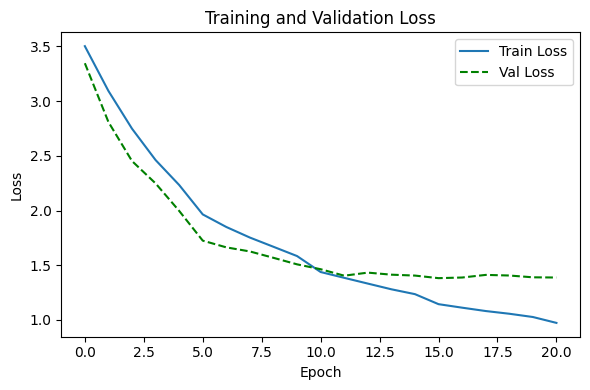


最終測試集準確率: 56.89%
Precision: 0.5851
Recall:    0.5689
F1-score:  0.5601


In [2]:
# -------------------------------
# 資料路徑
# -------------------------------
train_csv = "train.csv"
val_csv = "val.csv"
test_csv = "test.csv"

# -------------------------------
# Normalization 參數（寫死）
# -------------------------------
train_mean = [0.48, 0.46, 0.39]
train_std = [0.24, 0.23, 0.24]

normalize_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

# -------------------------------
# Dataset 類別
# -------------------------------
class ImageDatasetFromCSV(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['full_path']
        label = int(self.df.iloc[idx]['label'])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# -------------------------------
# 建立 DataLoader
# -------------------------------
batch_size = 64
train_dataset = ImageDatasetFromCSV(train_csv, transform=normalize_transform)
val_dataset = ImageDatasetFromCSV(val_csv, transform=normalize_transform)
test_dataset = ImageDatasetFromCSV(test_csv, transform=normalize_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# -------------------------------
# 符合 TaskB 的 EfficientNet-like 精簡模型（4 個有效層，移除 SE Block）
# -------------------------------
class EfficientNetMini(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False)  
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=7, stride=2, padding=3, bias=False)  
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=7, stride=2, padding=3, bias=False) 
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=7, stride=2, padding=3, bias=False) 
        self.bn4 = nn.BatchNorm2d(128)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = F.silu(self.bn1(self.conv1(x)))
        x = F.silu(self.bn2(self.conv2(x)))
        x = F.silu(self.bn3(self.conv3(x)))
        x = F.silu(self.bn4(self.conv4(x)))
        x = self.pool(x).view(x.size(0), -1)
        return self.fc(x)

num_classes = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetMini(num_classes).to(device)

print("\n模型參數與 FLOPs 統計：")
with torch.cuda.device(0):
    macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True,
                                             print_per_layer_stat=False, verbose=False)
print(f"FLOPs (MACs): {macs}")
print(f"參數總數（格式化）: {params}")
total_params = sum(p.numel() for p in model.parameters())
print(f"參數總數（數字）: {total_params:,}")

# -------------------------------
# 模型訓練與驗證（增加 Epoch 輸出）
# -------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
num_epochs = 30
train_losses, val_losses = [], []

best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    train_acc = correct_train / total_train

    model.eval()
    val_running_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    val_epoch_loss = val_running_loss / len(val_loader)
    val_losses.append(val_epoch_loss)
    val_acc = correct_val / total_val

    end_time = time.time()
    duration = end_time - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}, "
          f"Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%, Time: {duration:.2f} sec")

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping: validation loss did not improve for {patience} epochs.")
            break

    scheduler.step()

# -------------------------------
# 畫出 Loss 曲線
# -------------------------------
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss", linestyle="--", color="green")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 測試集準確率與其他指標
# -------------------------------
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"\n最終測試集準確率: {acc * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")